In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp

from utils.loss import DiceLoss, DiceCrossEntropyLoss
from utils.dataset import BrainMRISliceDataset
from utils.utils import train, validate
from utils.metric import MetricsMonitor, dice_coefficient
from utils.vis import plot_mri

/root/miniconda3/envs/py11/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Constants

In [2]:
ROOT_DIR = './Data/'
BATCH_SIZE = 32
EPOCHS = 300
DEVICE = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 0
LR = 0.01

## Transforms

In [3]:
train_transform = A.Compose([
    # A.Resize(256, 256),  # Resize both image and mask
    A.HorizontalFlip(p=0.5),  # Flip horizontally
    A.VerticalFlip(p=0.5),  # Flip vertically
    # A.RandomRotate90(p=0.5),  # Randomly rotate 90 degrees
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.5),
    # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),  
    A.LongestMaxSize(max_size=256),  # Resize the smallest side to 256, keeping the aspect ratio
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0),  # Pad to a square image
    A.Normalize(normalization="min_max", p=1.0),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize the image
    ToTensorV2()  # Convert to PyTorch tensors
], additional_targets={'mask': 'mask'})  # Specify the target name for the label

test_transform = A.Compose([
    # A.Resize(256, 256),
    A.LongestMaxSize(max_size=256),  # Resize the smallest side to 256, keeping the aspect ratio
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0),  # Pad to a square image
    A.Normalize(normalization="min_max", p=1.0),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

In [5]:
train_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'train'), slice_axis=2, transform=train_transform, num_classes=3, cache=True, ignore_background=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=2, transform=test_transform, num_classes=3, cache=True, ignore_background=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

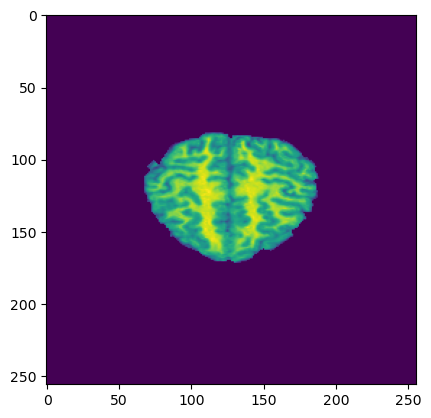

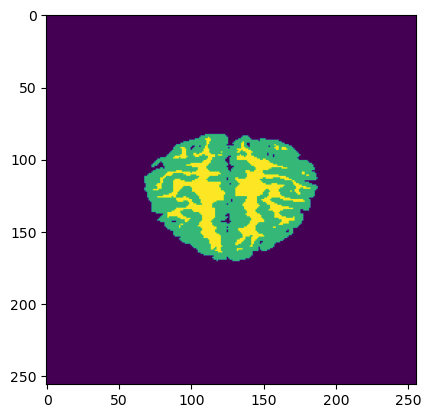

tensor(0.) tensor(1.)


In [6]:
image, mask = val_dataset[180]
plt.imshow(image.permute(2, 1, 0).numpy())
plt.show()

plt.imshow(mask.permute(2, 1, 0).numpy())
plt.show()
print (image.min(), image.max())

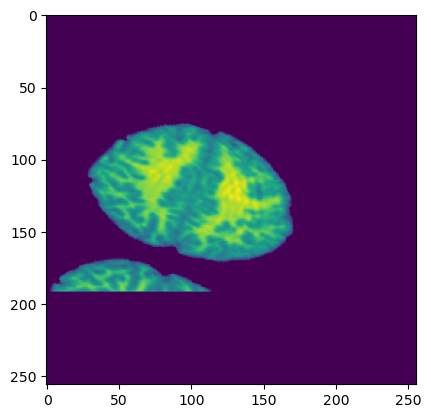

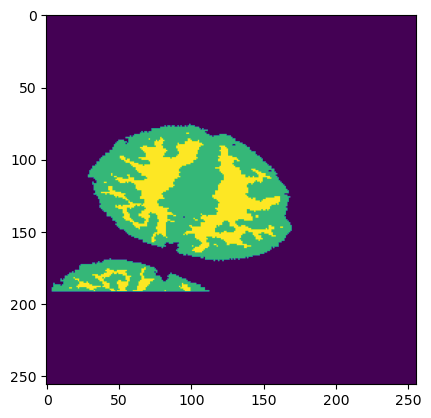

tensor(0.) tensor(1.)


In [7]:
image, mask = train_dataset[180]
plt.imshow(image.permute(2, 1, 0).numpy())
plt.show()

plt.imshow(mask.permute(2, 1, 0).numpy())
plt.show()
print (image.min(), image.max())

## Models

In [8]:
model = smp.Unet(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

model = model.to(DEVICE)

## Loss & Optimizer

In [9]:
# criteria =  torch.nn.CrossEntropyLoss()
# criteria = torch.nn.BCEWithLogitsLoss()
criteria = DiceCrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

## Training

In [10]:
# Monitors
train_monitor = MetricsMonitor(metrics=["loss", "dice_score"])
val_monitor = MetricsMonitor(
    metrics=["loss", "dice_score"], patience=5, mode="max"
)
test_monitor = MetricsMonitor(metrics=["loss", "dice_score"])

In [11]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    train(model, train_loader, criteria, optimizer, DEVICE, train_monitor)
    scheduler.step()
    validate(model, val_loader, criteria, DEVICE, val_monitor)

Epoch 1/300
----------


[Train] Iteration 80/80 - loss: 0.3434, dice_score: 0.4264
Train Metrics - loss: 0.3434, dice_score: 0.4264
[Validation] Iteration 40/40 - loss: 21.7605, dice_score: 0.2414
Validation Metrics - loss: 21.7605, dice_score: 0.2414
Epoch 2/300
----------
[Train] Iteration 80/80 - loss: 0.2643, dice_score: 0.5008
Train Metrics - loss: 0.2643, dice_score: 0.5008
[Validation] Iteration 40/40 - loss: 0.4199, dice_score: 0.3356
Validation Metrics - loss: 0.4199, dice_score: 0.3356
Epoch 3/300
----------
[Train] Iteration 80/80 - loss: 0.2568, dice_score: 0.5145
Train Metrics - loss: 0.2568, dice_score: 0.5145
[Validation] Iteration 40/40 - loss: 0.3781, dice_score: 0.3603
Validation Metrics - loss: 0.3781, dice_score: 0.3603
Epoch 4/300
----------
[Train] Iteration 80/80 - loss: 0.2519, dice_score: 0.5221
Train Metrics - loss: 0.2519, dice_score: 0.5221
[Validation] Iteration 40/40 - loss: 0.3204, dice_score: 0.4142
Validation Metrics - loss: 0.3204, dice_score: 0.4142
Epoch 5/300
----------
[T

KeyboardInterrupt: 

In [ ]:
## Export Model
torch.save(model.state_dict(), "model.pth")

## Predict

In [ ]:
predictions = []
labels = []

model.eval()
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(val_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)
        predictions.append(outputs)
        labels.append(masks)
        
predictions = torch.cat(predictions, dim=0)
labels = torch.cat(labels, dim=0).squeeze(1).long()
dice_scores = dice_coefficient(predictions, labels, num_classes=4)
print(dice_scores)

[0.998099148273468, 0.9186011552810669, 0.9377807974815369, 0.8980585336685181]


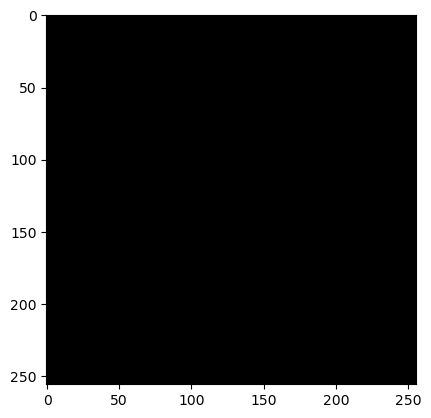

In [ ]:
outputs = torch.argmax(predictions, dim=1)
plt.imshow(outputs[15].cpu().numpy(), cmap='gray')

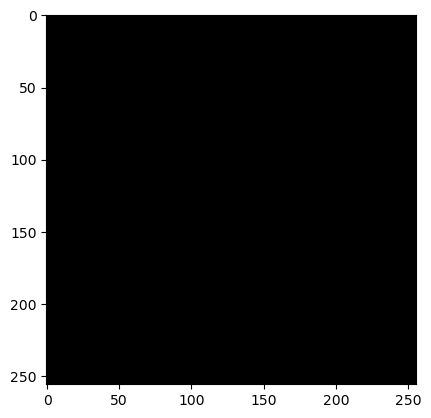

In [ ]:
plt.imshow(masks[15].permute(1, 2, 0).cpu().numpy(),  cmap='gray')